In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from yahoofinancials import YahooFinancials

In [2]:
data=yf.download('^HSI','2020-01-01','2022-01-01')
data=data.drop('Volume',1)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_73701/2406772009.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data=data.drop('Volume',1)


,Open,High,Low,Close,Adj Close,Prediction
Date,,,,,,
2020-01-02,28249.369141,28543.519531,28245.970703,28543.519531,28543.519531,28451.500000
2020-01-03,28828.359375,28883.300781,28428.169922,28451.500000,28451.500000,28226.189453
2020-01-06,28326.500000,28367.869141,28054.289062,28226.189453,28226.189453,28322.060547
2020-01-07,28352.679688,28473.080078,28264.070312,28322.060547,28322.060547,28087.919922
2020-01-08,27999.580078,28198.609375,27857.730469,28087.919922,28087.919922,28561.000000
...,...,...,...,...,...,...
2021-12-23,23141.789062,23264.750000,23027.150391,23193.640625,23193.640625,23223.759766
2021-12-24,23375.990234,23383.189453,23186.570312,23223.759766,23223.759766,23280.560547
2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547,23086.539062


In [3]:
# data['6day MA'] = data['Close'].rolling(window = 6).mean()
# data['12day MA'] = data['Close'].rolling(window = 12).mean()
# data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
# data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
# data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
# data['MI6']=talib.MOM(data['Close'],timeperiod=6)
# data['MI12']=talib.MOM(data['Close'],timeperiod=12)
# macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
# data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
# data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
# data['MACD']=macd
# data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
# data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
# data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [4]:
data_val=data[-100:]
data=data[:-100]

In [5]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [6]:
X=sc.fit_transform(data.drop('Prediction',1))
# X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Prediction"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(314, 1, 5) (314,) (79, 1, 5) (79,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_73701/1866109569.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [7]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-12 15:58:46.991965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-12 15:58:46.992076: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
)
y_pred = model_tech.predict(X_test)

Epoch 1/500


2022-04-12 15:58:48.007305: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-12 15:58:49.250144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 15:58:49.495296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 15:58:49.992768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 15:58:51.281087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 15:58:51.765563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 6s 89ms/step - loss: 668073408.0000 - val_loss: 834494720.0000
Epoch 2/500
 7/18 [==========>...................] - ETA: 0s - loss: 644846400.0000

2022-04-12 15:58:53.405403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 15:58:53.478848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 15:58:53.502503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 10ms/step - loss: 668048768.0000 - val_loss: 834460032.0000
Epoch 3/500
18/18 [==============================] - 0s 9ms/step - loss: 667977344.0000 - val_loss: 834372224.0000
Epoch 4/500
18/18 [==============================] - 0s 10ms/step - loss: 667737344.0000 - val_loss: 834158336.0000
Epoch 5/500
18/18 [==============================] - 0s 10ms/step - loss: 666993280.0000 - val_loss: 833695744.0000
Epoch 6/500
18/18 [==============================] - 0s 10ms/step - loss: 665228864.0000 - val_loss: 832694400.0000
Epoch 7/500
18/18 [==============================] - 0s 10ms/step - loss: 662291008.0000 - val_loss: 830375424.0000
Epoch 8/500
18/18 [==============================] - 0s 9ms/step - loss: 658418048.0000 - val_loss: 825800832.0000
Epoch 9/500
18/18 [==============================] - 0s 10ms/step - loss: 653865920.0000 - val_loss: 819382208.0000
Epoch 10/500
18/18 [==============================] - 0s 10ms/step - loss: 648966784.0

18/18 [==============================] - 0s 10ms/step - loss: 194292864.0000 - val_loss: 281994624.0000
Epoch 73/500
18/18 [==============================] - 0s 10ms/step - loss: 187585808.0000 - val_loss: 273828480.0000
Epoch 74/500
18/18 [==============================] - 0s 9ms/step - loss: 180999888.0000 - val_loss: 265785392.0000
Epoch 75/500
18/18 [==============================] - 0s 9ms/step - loss: 174537648.0000 - val_loss: 257868400.0000
Epoch 76/500
18/18 [==============================] - 0s 9ms/step - loss: 168201440.0000 - val_loss: 250080416.0000
Epoch 77/500
18/18 [==============================] - 0s 9ms/step - loss: 161993408.0000 - val_loss: 242424128.0000
Epoch 78/500
18/18 [==============================] - 0s 9ms/step - loss: 155915584.0000 - val_loss: 234902016.0000
Epoch 79/500
18/18 [==============================] - 0s 10ms/step - loss: 149969712.0000 - val_loss: 227516384.0000
Epoch 80/500
18/18 [==============================] - 0s 9ms/step - loss: 14415744

18/18 [==============================] - 0s 10ms/step - loss: 5317934.0000 - val_loss: 19063444.0000
Epoch 144/500
18/18 [==============================] - 0s 9ms/step - loss: 5150533.0000 - val_loss: 18486340.0000
Epoch 145/500
18/18 [==============================] - 0s 9ms/step - loss: 4998670.5000 - val_loss: 17940916.0000
Epoch 146/500
18/18 [==============================] - 0s 9ms/step - loss: 4861130.5000 - val_loss: 17425608.0000
Epoch 147/500
18/18 [==============================] - 0s 9ms/step - loss: 4736772.5000 - val_loss: 16938890.0000
Epoch 148/500
18/18 [==============================] - 0s 9ms/step - loss: 4624524.0000 - val_loss: 16479315.0000
Epoch 149/500
18/18 [==============================] - 0s 9ms/step - loss: 4523382.0000 - val_loss: 16045506.0000
Epoch 150/500
18/18 [==============================] - 0s 9ms/step - loss: 4432410.0000 - val_loss: 15636141.0000
Epoch 151/500
18/18 [==============================] - 0s 9ms/step - loss: 4350735.0000 - val_loss: 1

18/18 [==============================] - 0s 10ms/step - loss: 3763210.0000 - val_loss: 9413540.0000
Epoch 216/500
18/18 [==============================] - 0s 9ms/step - loss: 3763458.7500 - val_loss: 9410203.0000
Epoch 217/500
18/18 [==============================] - 0s 10ms/step - loss: 3763698.0000 - val_loss: 9407179.0000
Epoch 218/500
18/18 [==============================] - 0s 9ms/step - loss: 3763927.2500 - val_loss: 9404448.0000
Epoch 219/500
18/18 [==============================] - 0s 9ms/step - loss: 3764145.7500 - val_loss: 9401971.0000
Epoch 220/500
18/18 [==============================] - 0s 9ms/step - loss: 3764354.7500 - val_loss: 9399738.0000
Epoch 221/500
18/18 [==============================] - 0s 9ms/step - loss: 3764555.0000 - val_loss: 9397729.0000
Epoch 222/500
18/18 [==============================] - 0s 9ms/step - loss: 3764748.2500 - val_loss: 9395918.0000
Epoch 223/500
18/18 [==============================] - 0s 9ms/step - loss: 3764932.2500 - val_loss: 9394303.

18/18 [==============================] - 0s 9ms/step - loss: 534170.3125 - val_loss: 1476568.2500
Epoch 288/500
18/18 [==============================] - 0s 10ms/step - loss: 517236.7812 - val_loss: 1395138.7500
Epoch 289/500
18/18 [==============================] - 0s 9ms/step - loss: 501106.8438 - val_loss: 1318137.5000
Epoch 290/500
18/18 [==============================] - 0s 10ms/step - loss: 485722.7500 - val_loss: 1245293.2500
Epoch 291/500
18/18 [==============================] - 0s 9ms/step - loss: 471034.7500 - val_loss: 1176369.7500
Epoch 292/500
18/18 [==============================] - 0s 10ms/step - loss: 457001.6875 - val_loss: 1111135.6250
Epoch 293/500
18/18 [==============================] - 0s 9ms/step - loss: 443586.4062 - val_loss: 1049374.7500
Epoch 294/500
18/18 [==============================] - 0s 9ms/step - loss: 430759.3438 - val_loss: 990898.6250
Epoch 295/500
18/18 [==============================] - 0s 11ms/step - loss: 418498.6250 - val_loss: 935545.8750
Epoc

18/18 [==============================] - 0s 9ms/step - loss: 163890.1406 - val_loss: 144949.1719
Epoch 361/500
18/18 [==============================] - 0s 9ms/step - loss: 163020.6250 - val_loss: 145471.6250
Epoch 362/500
18/18 [==============================] - 0s 9ms/step - loss: 162177.0312 - val_loss: 145994.7500
Epoch 363/500
18/18 [==============================] - 0s 9ms/step - loss: 161357.6250 - val_loss: 146517.7188
Epoch 364/500
18/18 [==============================] - 0s 9ms/step - loss: 160562.2500 - val_loss: 147036.7188
Epoch 365/500
18/18 [==============================] - 0s 9ms/step - loss: 159789.4531 - val_loss: 147548.5938
Epoch 366/500
18/18 [==============================] - 0s 9ms/step - loss: 159037.9844 - val_loss: 148051.8594
Epoch 367/500
18/18 [==============================] - 0s 9ms/step - loss: 158307.7188 - val_loss: 148541.8750
Epoch 368/500
18/18 [==============================] - 0s 9ms/step - loss: 157597.6250 - val_loss: 149020.9219
Epoch 369/500
1

18/18 [==============================] - 0s 10ms/step - loss: 134548.1094 - val_loss: 169081.0781
Epoch 434/500
18/18 [==============================] - 0s 9ms/step - loss: 134391.4531 - val_loss: 169372.3125
Epoch 435/500
18/18 [==============================] - 0s 10ms/step - loss: 134238.2188 - val_loss: 169659.5938
Epoch 436/500
18/18 [==============================] - 0s 10ms/step - loss: 134088.2031 - val_loss: 169947.7344
Epoch 437/500
18/18 [==============================] - 0s 10ms/step - loss: 133941.2031 - val_loss: 170232.2812
Epoch 438/500
18/18 [==============================] - 0s 9ms/step - loss: 133796.8906 - val_loss: 170517.2812
Epoch 439/500
18/18 [==============================] - 0s 9ms/step - loss: 133655.9688 - val_loss: 170799.7031
Epoch 440/500
18/18 [==============================] - 0s 9ms/step - loss: 133517.4688 - val_loss: 171082.1406
Epoch 441/500
18/18 [==============================] - 0s 9ms/step - loss: 133381.8125 - val_loss: 171361.3438
Epoch 442/5

2022-04-12 16:00:19.446340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 16:00:19.516985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 16:00:19.547552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


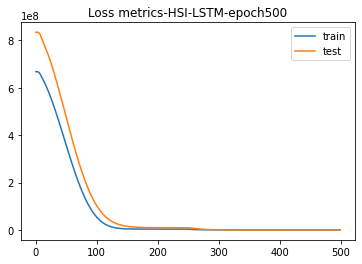

In [9]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.title('Loss metrics-HSI-LSTM-epoch500')
plt.legend()

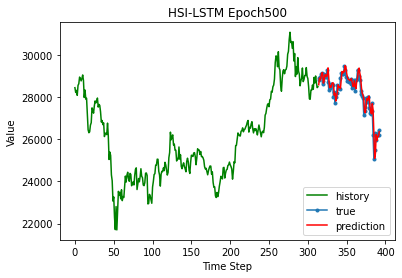

In [10]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
# plt.plot(np.arange(0, len(y_train)), sc_y.inverse_transform(y_train), 'g', label="history")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_test), marker='.', label="true")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM Epoch500')
plt.legend()
plt.show()

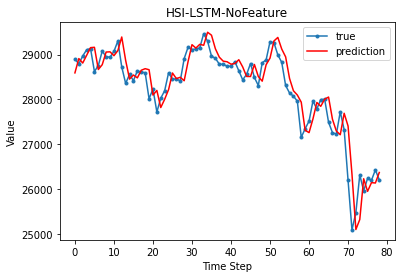

In [11]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM-NoFeature')
plt.legend()
plt.show();

In [12]:
r2_score(y_test,y_pred)

0.8565963136269249

In [13]:
mean_absolute_percentage_error(y_test,y_pred)

0.009756502318003688

In [14]:
mean_squared_error(y_test,y_pred,squared=False)

367.5908594784261

In [15]:
x_val=data_val.drop('Prediction',1).values
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_73701/264374676.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1).values
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


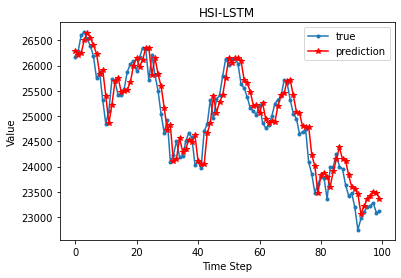

In [16]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM')
plt.legend()
plt.show()

In [17]:
r2_score(y_val,y_val_pred)

0.8982755694831129

In [18]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.010577985308755566

In [19]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

319.36947092884816